<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/tmp/caox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Deep Learning

In [ ]:
#! pip install imbalanced-learn
#! pip install -U keras-tuner

In [353]:
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from kerastuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

## Data Preparation

In [86]:
#! git clone https://github.com/Superzchen/iFeature
! python iFeature/iFeature.py --file drive/My\ Drive/sample_test.fasta --type AAC --out AAC.txt
index_df = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/tmp/sample.txt",sep="\t")
cdf = pd.merge(df_c,index_df,on='id')
cdf
#Check Imbalance
#cdf['cat'].value_counts()
df = pd.read_csv("AAC.txt",sep="\t")
df2 = df.rename({'#': 'id'}, axis='columns')
df_02 = pd.DataFrame(df2.id.str.split('|',1).tolist(),columns = ['A','B'])
df_03 = pd.DataFrame(df_02.B.str.split('|',1).tolist(),columns = ['id','B'])
df_c = pd.concat([df_03.iloc[:,0], df.iloc[:,1:21]], axis=1)
cdf = pd.merge(df_c,index_df,on='id')
cdf['cat'].value_counts()
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=100)
count_df = pd.DataFrame(y_train) 
count_df['cat'].value_counts()

Descriptor type: AAC


In [402]:
#split before Sim
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]

X_train_pre, X_test, y_train_pre, y_test = train_test_split(X,Y, test_size=0.20, random_state=100)
count_df = pd.DataFrame(y_test) 
count_df['cat'].value_counts()

# Simulate Data
oversample = SMOTE(sampling_strategy = {
  1: 1000,
  0: 1000
})
X_train, y_train = oversample.fit_sample(X_train_pre,y_train_pre)

#count_df = pd.DataFrame(y_train) 
#count_df['cat'].value_counts()


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 115)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 115)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureW

##Model Reconstruction

In [424]:
def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[X_train.shape[1]]
    ))
    
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(56, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss = 'binary_crossentropy',
        metrics = ['accuracy',sensitivity, specificity])
    return model

In [426]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='test_dir_b2skf0gdfbhhghsc0',
    project_name='b_tune_nn',
    seed=100
)

In [ ]:
b_tuner.search(x=X_train,
             y=y_train,
             epochs=20,
             validation_data=(X_test, y_test))

In [428]:
b_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'drop_rate': 0.1, 'learning_rate': 0.0001}

## Model Evaluation

In [ ]:
best_model = b_tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, epochs=200, verbose=1, validation_split=0.3)

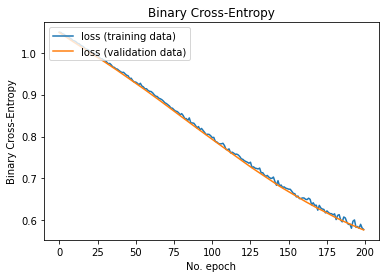

In [430]:
plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['val_loss'], label='loss (validation data)')
plt.title('Binary Cross-Entropy')
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

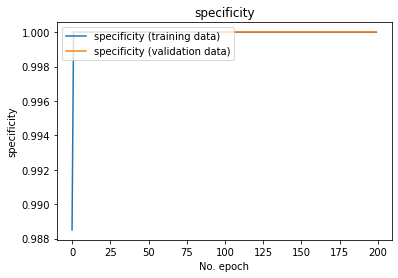

In [431]:
plt.plot(history.history['specificity'], label='specificity (training data)')
plt.plot(history.history['val_specificity'], label='specificity (validation data)')
plt.title('specificity')
plt.ylabel('specificity')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

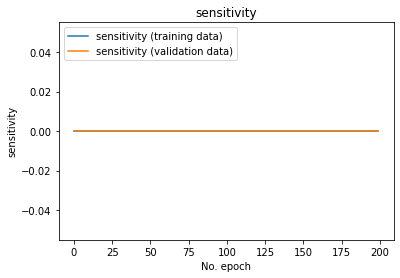

In [432]:
plt.plot(history.history['sensitivity'], label='sensitivity (training data)')
plt.plot(history.history['val_sensitivity'], label='sensitivity (validation data)')
plt.title('sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

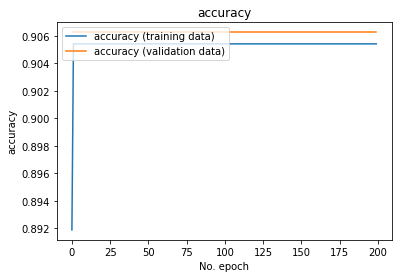

In [433]:
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

In [ ]:
from sklearn.metrics import roc_curve
best_model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.3)
y_pred_keras = best_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)


In [364]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.7517730496453902

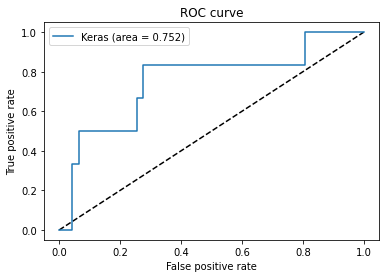

In [365]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# SVM

In [435]:
import numpy as np
import pandas as pd

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss

from sklearn.svm import SVC
from sklearn import decomposition

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

In [453]:
#! git clone https://github.com/Superzchen/iFeature
! python iFeature/iFeature.py --file drive/My\ Drive/sample_test.fasta --type AAC --out AAC.txt
index_df = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/tmp/sample.txt",sep="\t")
cdf = pd.merge(df_c,index_df,on='id')
#Check Imbalance
#cdf['cat'].value_counts()
df = pd.read_csv("AAC.txt",sep="\t")
df2 = df.rename({'#': 'id'}, axis='columns')
df_02 = pd.DataFrame(df2.id.str.split('|',1).tolist(),columns = ['A','B'])
df_03 = pd.DataFrame(df_02.B.str.split('|',1).tolist(),columns = ['id','B'])
df_c = pd.concat([df_03.iloc[:,0], df.iloc[:,1:21]], axis=1)
cdf = pd.merge(df_c,index_df,on='id')
cdf['cat'].value_counts()
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]

Descriptor type: AAC


In [459]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid','linear']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.800000 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.800000 (0.331662) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.700000 (0.400000) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.100000 (0.270801) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}
0.800000 (0.331662) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.650000 (0.390512) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.700000 (0.378594) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
0.250000 (0.359398) with: {'C': 0.1, 'gamma': 'scale'

# Logistic Regression

In [458]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.066667 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.066667 (0.213437) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.066667 (0.213437) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.066667 (0.213437) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) wit

#BaggingClassifier

In [457]:
# example of grid searching key hyperparameters for BaggingClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.450000 using {'n_estimators': 100}
0.366667 (0.426875) with: {'n_estimators': 10}
0.450000 (0.415331) with: {'n_estimators': 100}
0.433333 (0.422953) with: {'n_estimators': 1000}


#Random Forest

In [456]:
# example of grid searching key hyperparameters for RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.266667 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.133333 (0.314466) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.066667 (0.169967) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.266667 (0.402768) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.200000 (0.355903) with: {'max_features': 'log2', 'n_estimators': 10}
0.150000 (0.320156) with: {'max_features': 'log2', 'n_estimators': 100}
0.183333 (0.328718) with: {'max_features': 'log2', 'n_estimators': 1000}
